In [1]:
import sys

sys.path.append('./source/')
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy.interpolate import interp1d
from scipy import interpolate as intp
import importlib
import json

from source import plots
from source import prob_dists as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%pwd

'/Users/runburg/github/dm_gal_substructure'

In [3]:
n = 0
importlib.reload(pd)
importlib.reload(plots)
params = {'R_G': 220, # Kpc
          'd_solar': 8.5, # kpc
          'psi': 40,
          'M_min': 1.0e-2, # Msun
          'M_max': 1.0e10, # Msun
          'fwimp': 1.0,
          'mean_params': {'a':77.4, 'b':0.87+0.31*n, 'c':-0.23-0.04*n},
          'nside': 128,
          'area_fermi': 2000.0, # cm^2
          'n': n,
          'log_flux_min': -15, # log10 photons/cm^2/yr
          'log_flux_max': -5, # log10 photons/cm^2/yr
          'N': 1000,
          'log_k_min': -3,
#           'log_k_min': 2,
          'log_k_max': 6,
#           'log_k_max': 6.5,
          'N_k': 250000,
          'psh_log_f_min': -5,
#           'psh_log_f_min': -4.5,
#           'psh_log_f_max': -4.7,
          'psh_log_f_max': -3.5,
          'N_psh': 500
         }

params['omega_pixel'] = 4.*np.pi/(12*params['nside']**2.) # sr
p = params
json.dump(p, open('source/n0.params', 'w'), indent=0)

In [2]:
p = json.load(open('source/n0.params', 'r'))
p

{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.01,
 'M_max': 10000000000.0,
 'fwimp': 1.0,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -15,
 'log_flux_max': -5,
 'N': 1000,
 'log_k_min': -3,
 'log_k_max': 6,
 'N_k': 250000,
 'psh_log_f_min': -5,
 'psh_log_f_max': -3.5,
 'N_psh': 500,
 'omega_pixel': 6.391586616190171e-05}

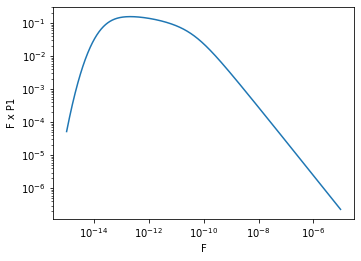

In [3]:
fluxes = np.logspace(p['log_flux_min'], p['log_flux_max'], num=p['N'])
p1_vals = pd.p1(fluxes, **p)
fig, _ = plots.check_fp1_plot(fluxes, p1_vals)

In [4]:
muu = pd.mu(**p)
print(muu)
ft_p1_vals, k = pd.ft_p1(p1_vals, fluxes, **p)
fig, _ = plots.check_ft_p1_plot(k, ft_p1_vals)

[1058870.35034894]


KeyboardInterrupt: 

In [ ]:
print(muu)
fig, _ = plots.check_psh_integrand_plot(k, ft_p1_vals, muu)

In [ ]:
print(muu)

In [ ]:
pf_vals, flux = pd.pf(muu, ft_p1_vals, k, **p)

In [ ]:
startl = 10
limi = -60
fig, _ = plots.check_psh_plot(flux, pf_vals.real, j=[startl, limi])

# print(pf_vals)

In [ ]:
print(f'\mu \int F P1: {(muu[0] * integrate.simps(fluxes * p1_vals, fluxes))}')
print(f' \int F Psh: {integrate.simps(pf_vals[startl:limi].real * flux[startl:limi], flux[startl:limi])}')


In [ ]:
np.trapz(pf_vals[startl:limi].real, flux[startl:limi])

In [ ]:
pshvals, fxs = pd.psh(params, plot=False, infer_values=True)

In [ ]:
plt.plot(fxs, fxs * pshvals.real)
ax = plt.gca()
startl = 0
limi = -1
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(fxs[startl], color='b')
ax.axvline(fxs[limi], color='b')

print(f' \int F Psh: {integrate.simps(pshvals[startl:limi].real * fxs[startl:limi], fxs[startl:limi])}')



In [ ]:
pshop, fluxes, psis = pd.psh_of_psi(p, num_psi=10, infer_values=True)

In [ ]:
plots.psh_func_psi_plot(pshop, fluxes, psis, outfile='./output/n0_psh_of_psi.png')

In [ ]:
importlib.reload(pd)
psh_2dfunc = pd.interp_and_save_psh(p, pshop, fluxes, psis, outfile='./output/n0_pshfunc.npz')

In [ ]:
numnum = 100
psis = np.linspace(40, 90, num=numnum)
colors = cm.viridis(np.linspace(0, 1, num=numnum))

fig, ax = plt.subplots()

psh_vals_over_psi = []
fxs = flux
for psi, col in zip(psis, colors):
    ax.plot(fxs, fxs * psh_2dfunc(psi, fxs).flatten(), label=rf"{psi}$^\circ$", color=col, lw=0.5)
   
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('F')
ax.set_ylabel('F x Psh')
cbarlabs = np.arange(min(psis), max(psis)+1, step=10)
cbar = fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ticks=np.linspace(0, 1, num=len(cbarlabs)))
cbar.set_label(r'$\psi$[$^\circ$]', rotation=270)
cbar.ax.set_yticklabels(cbarlabs)

In [55]:
with np.load('./output/n0_pshfunc.npz') as f:
    psi = f['psi']
    fluxes = f['flux']
    psh2d = f['psh']

pshfunc2d = intp.interp2d(psi, fluxes, psh2d, bounds_error=False, fill_value=0)
fluxes = fluxes[0:-55]

0.9993046434630801
0.9994936187123216
0.9996437983965932
0.9997622232751685
0.9998551438686257
0.9999269229409338
0.9999879785361636
1.0000394686975425
1.0000809029185755
1.0001130523799107
1.000139326916739
1.000160373978742
1.0001760209791413
1.0001883415096815
1.0001985267399147
1.0002069077439861
1.0002131205496916
1.00021764418111
1.0002205852333288
1.0002218938484764


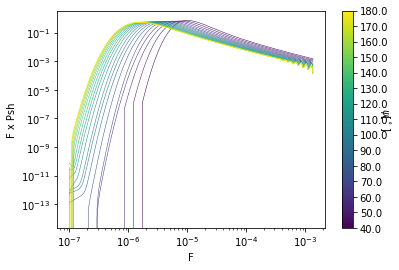

In [58]:
numnum = 20
psis = np.linspace(40, 180, num=numnum)
colors = cm.viridis(np.linspace(0, 1, num=numnum))

fig, ax = plt.subplots()

psh_vals_over_psi = []
fxs = fluxes
for psi, col in zip(psis, colors):
    ax.plot(fxs, fxs * pshfunc2d(psi, fxs).flatten(), label=rf"{psi}$^\circ$", color=col, lw=0.5)
    print(np.trapz(pshfunc2d(psi, fxs).flatten(), fxs))
   
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('F')
ax.set_ylabel('F x Psh')
cbarlabs = np.arange(min(psis), max(psis)+1, step=10)
cbar = fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ticks=np.linspace(0, 1, num=len(cbarlabs)))
cbar.set_label(r'$\psi$[$^\circ$]', rotation=270)
cbar.ax.set_yticklabels(cbarlabs);

In [ ]:
psh_2dfunc = pd.interp_and_save_psh(p, pshop, fluxes, psis, outfile='./output/n0_pshfunc.npz')